In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/data_download_all.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
# unpacking json
records = []
for identifier, value in data.items():
    trials = value["log"]["trials"]
    for trial in trials:
        record = {
            "identifier": identifier,
            "date": value["date"], 
            "condition": value["log"]["condition"],
            "trial": trial["trial"],
            "end_time": trial["end_time"],
            "start_time": trial["start_time"],
            "target": trial["target"],
            "entered": trial["entered"],
            "part": trial["part"],
            "block": trial["block"],
        }
        records.append(record)

# df from the list of dictionaries
df = pd.DataFrame(records)

In [4]:
# app-test filtering
df.groupby('identifier')['date'].agg(list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-01']

In [5]:
# filtering out empty trial (backend issue)
df = df.loc[df['trial'] != 32]

### metrics

In [6]:
# calculate wpm per trial
# from pypl: The WPM is calculated by dividing characters per second by five and then multiplying that with 60.

def calculate_wpm(row):
    characters_typed = len(row['entered']) # num of characters typed
    time_taken_sec = row['end_time'] - row['start_time'] # time taken
    wpm = ((characters_typed / time_taken_sec) / 5) * 60 # wpm 
    return wpm

df['wpm'] = df.apply(calculate_wpm, axis = 1)

In [7]:
# character error rate (from jiwer)
import jiwer

def calculate_cer(row):
    cer = jiwer.cer(row['target'], row['entered'])
    return cer

df['cer'] = df.apply(calculate_cer, axis = 1)

In [8]:
df.head()

,identifier,date,condition,trial,end_time,start_time,target,entered,part,block,wpm,cer
260,5691504483893248,2023-08-04 12:19:12,1,0,1691149786,1691149769,MY WATCH FELL IN THE WATER,MY WATCH FELL IN THE WATER,0,0,18.352941,0.000000
261,5691504483893248,2023-08-04 12:19:12,1,1,1691149813,1691149786,PREVAILING WIND FROM THE EAST,PREVAILING WIND FRLM THE EAST,0,0,12.888889,0.034483
262,5691504483893248,2023-08-04 12:19:12,1,2,1691149837,1691149813,NEVER TOO RICH AND NEVER TOO THIN,NEVER TOO RICH AND NEVER TOO THIN,0,0,16.500000,0.000000
263,5691504483893248,2023-08-04 12:19:12,1,3,1691149854,1691149837,BREATHING IS DIFFICULT,BREZTHING IS DIFFIWULT,0,0,15.529412,0.090909
264,5691504483893248,2023-08-04 12:19:12,1,4,1691149877,1691149854,I CAN SEE THE RINGS ON SATURN,I CAN SEE THE RINGS ON SATURN,0,0,15.130435,0.000000


### conditions

In [9]:
for index, row in df.iterrows():
    identifier = row['identifier']
    trial_num = row['trial']
    value = data.get(str(identifier), {})

    if value:
        trials = value["log"]["trials"]

        if trial_num < len(trials):
            trial = trials[trial_num]
            condition = value["log"]["condition"]
            part = trial["part"]
            keyboard = value["log"]["ux"][part]["keyboard"]

            # Assign the extracted "keyboard" value to the DataFrame
            df.at[index, 'keyboard'] = keyboard

In [10]:
print('cognitive wpm MEAN:', df[df["keyboard"] == "cognitive"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["wpm"].std(),
      '\nbaseline wpm MEAN:', df[df["keyboard"] == "baseline"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["wpm"].std(),
      '\ncognitive cer MEAN:', df[df["keyboard"] == "cognitive"]["cer"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["cer"].std(),
      '\nbaseline cer MEAN:', df[df["keyboard"] == "baseline"]["cer"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["wpm"].std())

cognitive wpm MEAN: 11.41393670074876  SD: 3.6120562547123454 
baseline wpm MEAN: 11.89593419694856  SD: 3.945299772355456 
cognitive cer MEAN: 0.010182218920450362  SD: 0.02930753310047151 
baseline cer MEAN: 0.021358006426805184  SD: 3.945299772355456


In [11]:
# # condition 0 = cognitive first
# 
# # map "keyboard" values based on condition and trial number
# def map_keyboard(row):
#     condition = row['condition']
#     part_one = row['part'] == 0
# 
#     if (condition == 0 and part_one) or (condition == 1 and not part_one):
#         return "cognitive"
# 
#     return "baseline"
# 
# df['keyboard'] = df.apply(map_keyboard, axis=1)

### tests

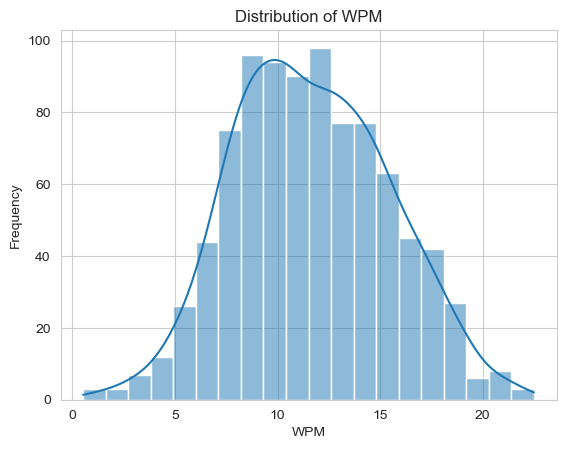

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='wpm', kde=True)
plt.title('Distribution of WPM')
plt.xlabel('WPM')
plt.ylabel('Frequency')
plt.show()

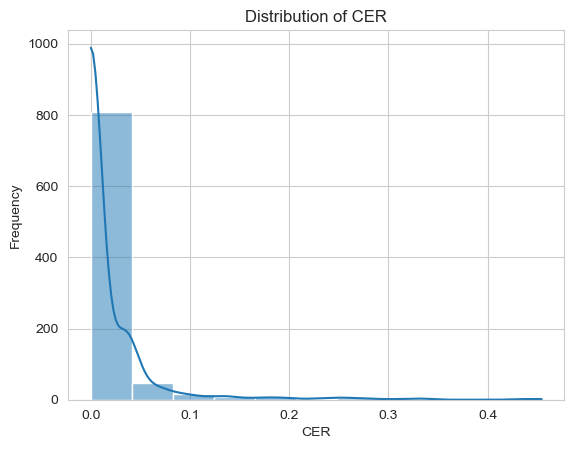

In [13]:
sns.histplot(data=df, x='cer', kde=True)
plt.title('Distribution of CER')
plt.xlabel('CER')
plt.ylabel('Frequency')
plt.show()

In [14]:
# # wpm
# 
# from scipy.stats import ttest_ind
# 
# cognitive_wpm = df.loc[df['keyboard'] == 'cognitive', 'wpm']
# baseline_wpm = df.loc[df['keyboard'] == 'baseline', 'wpm']
# 
# t_stat, p_value = ttest_ind(cognitive_wpm, baseline_wpm)
# 
# print("Two-Sample T-Test Results:")
# print("t-statistic:", t_stat)
# print("p-value:", p_value)
# 
# sns.histplot(data=df, x='wpm', hue='keyboard', kde=True)
# plt.title('Distribution of WPM for Cognitive and Baseline Keyboards')
# plt.xlabel('WPM')
# plt.ylabel('Frequency')
# plt.legend(title='Keyboard')
# plt.show()

In [15]:
# # cer
# 
# from scipy.stats import mannwhitneyu
# 
# cognitive_cer = df.loc[df['keyboard'] == 'cognitive', 'cer']
# baseline_cer = df.loc[df['keyboard'] == 'baseline', 'cer']
# 
# statistic, p_value = mannwhitneyu(cognitive_cer, baseline_cer)
# 
# print("Mann-Whitney U Test Results:")
# print("U-statistic:", statistic)
# print("p-value:", p_value)
# 
# sns.boxplot(data=df, x='keyboard', y='cer')
# plt.title('CER Comparison for Cognitive and Baseline Keyboards')
# plt.xlabel('Keyboard')
# plt.ylabel('Character Error Rate (CER)')
# plt.show()

### anova recalculation

In [26]:
df['block'].value_counts() # ???

0    112
1    112
2    112
3    112
5    112
6    112
7    112
4     98
8     14
Name: block, dtype: int64

In [28]:
df['block1'] = np.select(
    [
        (df['trial'] >= 0) & (df['trial'] <= 7) | (df['trial'] >= 33) & (df['trial'] <= 40),
        (df['trial'] >= 8) & (df['trial'] <= 15) | (df['trial'] >= 41) & (df['trial'] <= 48),
        (df['trial'] >= 16) & (df['trial'] <= 23) | (df['trial'] >= 49) & (df['trial'] <= 56),
        (df['trial'] >= 24) & (df['trial'] <= 31) | (df['trial'] >= 57) & (df['trial'] <= 64)
    ],
    [1, 2, 3, 4],
    default = None
)

In [32]:
import pingouin as pg

# repeated measures anova with interaction 
aov_interaction = pg.rm_anova(data=df, dv='wpm', within=['keyboard', 'block1'], subject = 'identifier')
print(aov_interaction)

# from statsmodels.stats.anova import AnovaRM
# aovrm = AnovaRM(df, 'wpm', 'identifier', within = ['keyboard', 'block1'], aggregate_func= 'mean')
# res = aovrm.fit()
# print(res)

              Source         SS  ddof1  ddof2        MS         F     p-unc  \
0           keyboard   6.505004      1     13  6.505004  1.513237  0.240443   
1             block1  24.262855      3     39  8.087618  7.245215  0.000561   
2  keyboard * block1   0.843161      3     39  0.281054  0.216687  0.884229   

   p-GG-corr       ng2       eps  
0   0.240443  0.006827  1.000000  
1   0.001870  0.024997  0.766902  
2   0.840325  0.000890  0.787124  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


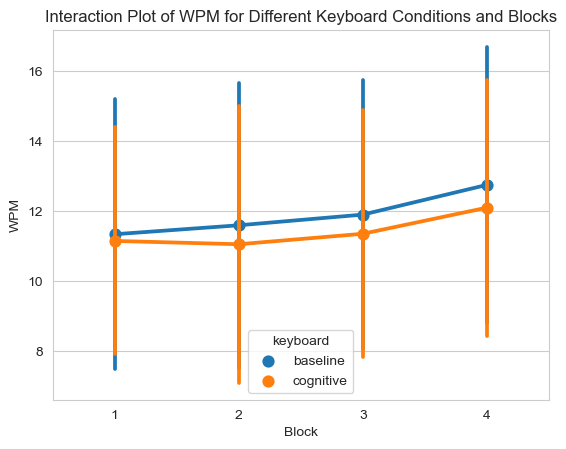

In [36]:
sns.pointplot(data = df, x = 'block1', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('Interaction Plot of WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


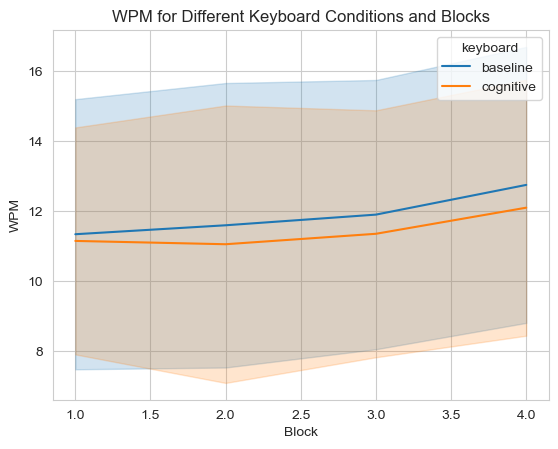

In [38]:
sns.lineplot(data = df, x = 'block1', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

In [39]:
from statsmodels.stats.multicomp import MultiComparison

multi_comp = MultiComparison(df['wpm'], df['keyboard'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1    group2  meandiff p-adj  lower  upper reject
------------------------------------------------------
baseline cognitive   -0.482 0.0568 -0.978 0.014  False
------------------------------------------------------


In [41]:
multi_comp = MultiComparison(df['wpm'], df['block1'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0805 0.9959 -0.8353 0.9963  False
     1      3   0.3815 0.7065 -0.5343 1.2973  False
     1      4   1.1775 0.0054  0.2617 2.0933   True
     2      3    0.301 0.8324 -0.6148 1.2168  False
     2      4    1.097 0.0113  0.1812 2.0128   True
     3      4    0.796 0.1141 -0.1198 1.7118  False
---------------------------------------------------


### sample size

In [6]:
import statsmodels.stats.power as smp

# Set the parameters for the power analysis
effect_size = 0.5 # Choose an appropriate effect size based on your domain knowledge
alpha = 0.05  # Significance level
power = 0.95  # Desired power

# Define the number of levels for each factor
num_keyboard_levels = 2
num_block_levels = 4

# Calculate the required sample size using the FTestAnovaPower class
required_sample_size = smp.FTestAnovaPower().solve_power(
    effect_size=effect_size,
    nobs=None,  # This is what we want to calculate
    alpha=alpha,
    power=power,
    k_groups=num_keyboard_levels * num_block_levels  # Degrees of freedom for error
)

print("Required Sample Size:", required_sample_size)

Required Sample Size: 94.65653188476638


In [ ]:
smp.FTestAnovaPower().solve_power( )